# Image Text Recognition 

## 1. Problem Statement

<p>Reading or Recognising Text from Images is a challenging Task in the field of Computer Vision. This is Mainly because Text in Images exhibit Diversity and Variability. Backgrounds of Images are virtually unpredictable as some images may have dark background, some may have light background and there are ven cases where image fonts and background have same color with a small outline differentiating Text from the Background. There might be patterns of Text appearing in the image with different fonts, orientations, and varying lengths. The Text in Images can also be blurred or distored</p> 
<p>So is there a way we can overcome these challeges and comeup with a solution which can recognise Text in a Variety of Images with a good accuracy?</p>

## 2. ML Problem

Given an input Image we need to predict the Text in the Image with a reasonable accuracy >80% (Exact match with the actual Text Labels) and should have a good letter match accuracy. 

### 2.1. Constraints

1. Low-Latency
2. Predict Text from Images with Variable length Labels/Words

### 2.2. Performance Metrics

1. CTC_loss during Training
2. Accuracy
3. Letter Accuracy

## 3. Dataset Overview

The Dataset used for this Case Study is **MJ Synth Dataset**

**Source:** https://www.robots.ox.ac.uk/~vgg/data/text/#sec-synth

1. **Train Data:** 200000 images from MJ Syth Dataset
2. **Validation Data:** 12000 images from MJ Syth Dataset
3. **Test Data:** 15000 images from MJ Syth Dataset 

### About Dataset

**MJ Synth Dataset**

The dataset consists of 9 million images in Grayscale covering 90k English words

In [1]:
from IPython.display import Image

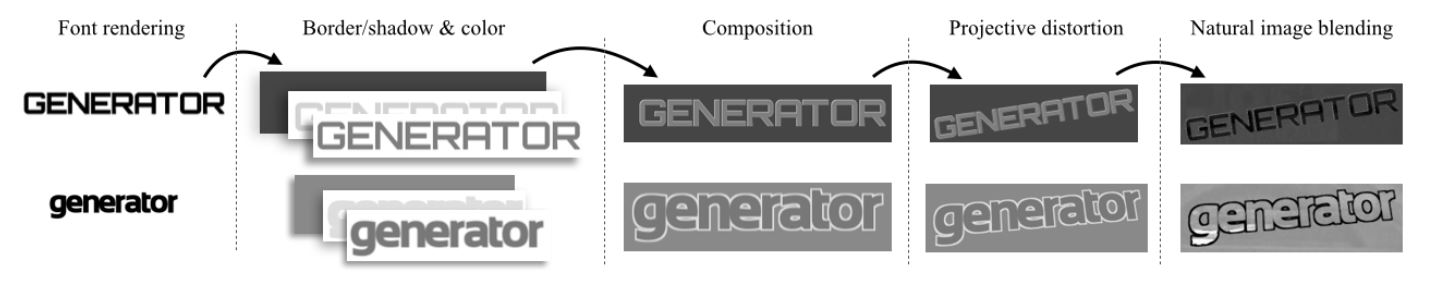

In [2]:
Image('Synth_Dataset.jpg')

## 4. Dataset Citation

@InProceedings{Jaderberg14c,
  author       = "Max Jaderberg and Karen Simonyan and Andrea Vedaldi and Andrew Zisserman",
  title        = "Synthetic Data and Artificial Neural Networks for Natural Scene Text Recognition",
  booktitle    = "Workshop on Deep Learning, NIPS",
  year         = "2014",
}

## 5. Data Preparation

In [1]:
import numpy as np
import pandas as pd
from PIL import Image as pilImg
import os 
import cv2
from datetime import datetime
import matplotlib.pyplot as plt
import itertools

Considering images with labels of length>=4 and length <=12 for this Case Study

**Preparing Train Data**

In [4]:
def Extract_image_names(file_path,number):
    """
    Takes the file path of images annotation txt file with the number of images names to be extracted
    and returns the list of file names having label length <=12
    """
    with open(file_path) as f:
        file_names=f.readlines()
        f.close()
        count=0
        img_names=[]
        for file in file_names:
            _,label,_=file.split('_')
            if len(label)>=4 and len(label)<=12:
                img_names.append(file)
                count+=1
            if count==number:
                break
        images_names=['SynthImageDataset'+x.strip() for x in img_names]
        return images_names

In [8]:
train_images= Extract_image_names('SynthImageDataset/annotation_train.txt',200000)

In [9]:
train_images[:5]

['SynthImageDataset./2425/1/115_Lube_45484.jpg 45484',
 'SynthImageDataset./2425/1/114_Spencerian_73323.jpg 73323',
 'SynthImageDataset./2425/1/112_CARPENTER_11682.jpg 11682',
 'SynthImageDataset./2425/1/110_savannas_67969.jpg 67969',
 'SynthImageDataset./2425/1/109_unfix_82473.jpg 82473']

The images names contains '.' after SynthImageDataset name which is an invalid file name so we need to remove '.' in begining without removing '.' which represents extention of images and we need to remove the number at the end as it is just the image serial number

In [10]:
def clean_file_names(file_names):
    clean_files=[]
    for file in file_names:
        main_folder,img_loc,extension=file.split('.')
        #Removing the image number at the end
        extension,_=extension.split(' ')
        img_file=main_folder+img_loc+'.'+extension
        clean_files.append(img_file)
    return clean_files

In [11]:
train_cleaned=clean_file_names(train_images)

In [12]:
train_cleaned[:5]

['SynthImageDataset/2425/1/115_Lube_45484.jpg',
 'SynthImageDataset/2425/1/114_Spencerian_73323.jpg',
 'SynthImageDataset/2425/1/112_CARPENTER_11682.jpg',
 'SynthImageDataset/2425/1/110_savannas_67969.jpg',
 'SynthImageDataset/2425/1/109_unfix_82473.jpg']

In [14]:
train_data=pd.DataFrame({'ImageName':train_cleaned})

In [15]:
train_data.head()

,ImageName
0,SynthImageDataset/2425/1/115_Lube_45484.jpg
1,SynthImageDataset/2425/1/114_Spencerian_73323.jpg
2,SynthImageDataset/2425/1/112_CARPENTER_11682.jpg
3,SynthImageDataset/2425/1/110_savannas_67969.jpg
4,SynthImageDataset/2425/1/109_unfix_82473.jpg


**The Ground Truth Values are present in the image file names, so we need to extract it and Store it in Ground Truth Column**

In [16]:
def extract_ground_truth(files):
    """
    Given the file names of images, extracts the Ground Truth Values and returns a list of Ground Truth Labels in All Capitals
    """
    txt_labels=[]
    for file in files:
        folder,ground_truth,image=file.split('_')
        ground_truth=ground_truth.upper()
        txt_labels.append(ground_truth)
    return txt_labels        

In [17]:
Train_ground_truths=extract_ground_truth(train_cleaned)

In [18]:
train_data['Labels']=Train_ground_truths

In [19]:
train_data.head()

,ImageName,Labels
0,SynthImageDataset/2425/1/115_Lube_45484.jpg,LUBE
1,SynthImageDataset/2425/1/114_Spencerian_73323.jpg,SPENCERIAN
2,SynthImageDataset/2425/1/112_CARPENTER_11682.jpg,CARPENTER
3,SynthImageDataset/2425/1/110_savannas_67969.jpg,SAVANNAS
4,SynthImageDataset/2425/1/109_unfix_82473.jpg,UNFIX


In [20]:
train_data.to_csv('Train_data.csv')

**Preparing Validation Data**

In [26]:
Validation_images=Extract_image_names('SynthImageDataset/annotation_val.txt',12000)

In [27]:
val_cleaned=clean_file_names(Validation_images)

In [28]:
val_data=pd.DataFrame({'ImageName':val_cleaned})

In [29]:
val_data.head()

,ImageName
0,SynthImageDataset/2697/6/466_MONIKER_49537.jpg
1,SynthImageDataset/2697/6/464_FIRESTORM_29099.jpg
2,SynthImageDataset/2697/6/462_Repurchases_64997...
3,SynthImageDataset/2697/6/461_PIGTAIL_57575.jpg
4,SynthImageDataset/2697/6/460_landladies_43270.jpg


In [30]:
Val_ground_truths=extract_ground_truth(val_cleaned)

In [31]:
val_data['Labels']=Val_ground_truths

In [32]:
val_data.head()

,ImageName,Labels
0,SynthImageDataset/2697/6/466_MONIKER_49537.jpg,MONIKER
1,SynthImageDataset/2697/6/464_FIRESTORM_29099.jpg,FIRESTORM
2,SynthImageDataset/2697/6/462_Repurchases_64997...,REPURCHASES
3,SynthImageDataset/2697/6/461_PIGTAIL_57575.jpg,PIGTAIL
4,SynthImageDataset/2697/6/460_landladies_43270.jpg,LANDLADIES


In [33]:
val_data.to_csv('Validation_data.csv')

**Preparing Test Data** 

In [34]:
test_images=Extract_image_names('SynthImageDataset/annotation_test.txt',15000)

In [35]:
test_cleaned=clean_file_names(test_images)

In [36]:
test_data=pd.DataFrame({'ImageName':test_cleaned})

In [37]:
test_data.head()

,ImageName
0,SynthImageDataset/3000/7/182_slinking_71711.jpg
1,SynthImageDataset/3000/7/181_REMODELERS_64541.jpg
2,SynthImageDataset/3000/7/180_Chronographs_1353...
3,SynthImageDataset/3000/7/179_Impeaching_38222.jpg
4,SynthImageDataset/3000/7/177_Loots_45256.jpg


In [38]:
test_ground_truths=extract_ground_truth(test_cleaned)

In [39]:
test_data['Labels']=test_ground_truths

In [40]:
test_data.head()

,ImageName,Labels
0,SynthImageDataset/3000/7/182_slinking_71711.jpg,SLINKING
1,SynthImageDataset/3000/7/181_REMODELERS_64541.jpg,REMODELERS
2,SynthImageDataset/3000/7/180_Chronographs_1353...,CHRONOGRAPHS
3,SynthImageDataset/3000/7/179_Impeaching_38222.jpg,IMPEACHING
4,SynthImageDataset/3000/7/177_Loots_45256.jpg,LOOTS


In [41]:
test_data.to_csv('Test_data.csv')

## 6. Image Processing -Converting to Single Channel

We need to Extract The images present in multiple folder paths in the original Big Data set and store them in a specified Train and Validation Data folder by taking the single channel gray scale images

In [43]:
def img_store_single_channel(destination_folder,files):
    """
    Takes the images in a folder, distination folder path and 
    converts the image to single channel gray scale,
    stores the image in the destination folder and returns image destination list
    """
    start=datetime.now()
    destination_list=[]
    count=1
    for file in files:
        #Removing the extra folder structures
        _,_,_,Name=file.split('/')
        _,img,_=Name.split('_')
        destination=destination_folder+str(count)+'_'+img+'.jpg'
        cv_img=cv2.imread(file)
        #So extracting image from any 1 channel gives a single channel Grayscale image
        cv_img_sc=cv_resized[:,:,1]
        cv2.imwrite(destination,cv_img_sc)
        destination_list.append(destination)
        count+=1
#         if count%10000==0:
#             print("Processed Images: ",count)
    print('Time Taken for Processing: ',datetime.now() - start)
    return destination_list

**Processing Train Data**

In [22]:
train_data=pd.read_csv('Train_data.csv')

In [23]:
train_data.drop(['Unnamed: 0'],axis=1,inplace=True)

In [40]:
train_files=train_data['ImageName'].values

In [44]:
train_dest=img_store_single_channel('Train_data/',train_files)

Processed Images:  10000
Processed Images:  20000
Processed Images:  30000
Processed Images:  40000
Processed Images:  50000
Processed Images:  60000
Processed Images:  70000
Processed Images:  80000
Processed Images:  90000
Processed Images:  100000
Processed Images:  110000
Processed Images:  120000
Processed Images:  130000
Processed Images:  140000
Processed Images:  150000
Processed Images:  160000
Processed Images:  170000
Processed Images:  180000
Processed Images:  190000
Processed Images:  200000
Time Taken for Processing:  1:37:36.491925


In [45]:
#Updating Train Dataframe with new destination file paths
train_data['ImageName']=train_dest

In [49]:
train_data.head()

,ImageName,Labels
0,Train_data/1_Lube.jpg,LUBE
1,Train_data/2_Spencerian.jpg,SPENCERIAN
2,Train_data/3_CARPENTER.jpg,CARPENTER
3,Train_data/4_savannas.jpg,SAVANNAS
4,Train_data/5_unfix.jpg,UNFIX


In [50]:
train_data.to_csv('Train_Final.csv')

**Processing Validation Data**

In [51]:
val_data=pd.read_csv('Validation_data.csv')

In [52]:
val_data.drop(['Unnamed: 0'],axis=1,inplace=True)

In [53]:
val_files=val_data['ImageName'].values

In [54]:
val_dest=img_store_single_channel('Val_data/',val_files)

Processed Images:  10000
Time Taken for Processing:  0:05:37.001844


In [55]:
#Updating Validation Dataframe with new destination file paths
val_data['ImageName']=val_dest

In [56]:
val_data.head()

,ImageName,Labels
0,Val_data/1_MONIKER.jpg,MONIKER
1,Val_data/2_FIRESTORM.jpg,FIRESTORM
2,Val_data/3_Repurchases.jpg,REPURCHASES
3,Val_data/4_PIGTAIL.jpg,PIGTAIL
4,Val_data/5_landladies.jpg,LANDLADIES


In [57]:
#Saving the updated Validation Dataframe
val_data.to_csv('Validation_Final.csv')

**Processing Test Data**

In [68]:
test_data=pd.read_csv('Test_data.csv')

In [69]:
test_data.drop(['Unnamed: 0'],axis=1,inplace=True)

In [70]:
test_files=test_data['ImageName'].values

In [71]:
test_dest=img_store_single_channel('Test_data/',test_files)

Time Taken for Processing:  0:09:11.791386


In [72]:
#Updating Test Dataframe with new destination file paths
test_data['ImageName']=test_dest

In [73]:
test_data.head()

,ImageName,Labels
0,Test_data/1_slinking.jpg,SLINKING
1,Test_data/2_REMODELERS.jpg,REMODELERS
2,Test_data/3_Chronographs.jpg,CHRONOGRAPHS
3,Test_data/4_Impeaching.jpg,IMPEACHING
4,Test_data/5_Loots.jpg,LOOTS


In [74]:
#Saving the updated Test Dataframe
test_data.to_csv('Test_Final.csv')

## 7. Exploratory Data Analysis

## 7.1. Image Size Analysis

In [2]:
train_data=pd.read_csv('Train_data.csv')
val_data=pd.read_csv('Validation_Data.csv')
test_data=pd.read_csv('Test_Data.csv')

In [17]:
def Write_Image_Sizes(filenames,storage_file):
    """
    Takes the File names, writes the width and height of images in csv along with file names
    """
    store_file=open(storage_file,'w+')
    store_file.write("ImageName,Height,Width")
    store_file.write("\n")
    cnt=0
    for file in filenames:
        cv_img=cv2.imread(file)
        #img.shape gives (img_height,img_width,img_channel)
        store_file.write(str(file)+","+str(cv_img.shape[0])+","+str(cv_img.shape[1]))
        store_file.write("\n")
        cnt+=1
        if cnt%10000==0:
            print("Processed Images: ",cnt)
    store_file.close()       

In [14]:
train_image_names=list(train_data['ImageName'].values)
val_image_names=list(val_data['ImageName'].values)
test_image_names=list(test_data['ImageName'].values)

In [18]:
Write_Image_Sizes(train_image_names,'Train_image_sizes.csv')

Processed Images:  10000
Processed Images:  20000
Processed Images:  30000
Processed Images:  40000
Processed Images:  50000
Processed Images:  60000
Processed Images:  70000
Processed Images:  80000
Processed Images:  90000
Processed Images:  100000
Processed Images:  110000
Processed Images:  120000
Processed Images:  130000
Processed Images:  140000
Processed Images:  150000
Processed Images:  160000
Processed Images:  170000
Processed Images:  180000
Processed Images:  190000
Processed Images:  200000


In [19]:
Write_Image_Sizes(val_image_names,'Validation_image_sizes.csv')

Processed Images:  10000


In [20]:
Write_Image_Sizes(test_image_names,'Test_image_sizes.csv')

Processed Images:  10000


In [21]:
train_img_size=pd.read_csv('Train_image_sizes.csv')
val_img_size=pd.read_csv('Validation_image_sizes.csv')
test_img_size=pd.read_csv('Test_image_sizes.csv')

In [22]:
train_img_size.describe()

,Height,Width
count,200000.000000,200000.000000
mean,31.038550,115.668015
std,0.333698,39.696249
min,9.000000,1.000000
25%,31.000000,88.000000
50%,31.000000,109.000000
75%,31.000000,136.000000
max,32.000000,608.000000


In [23]:
val_img_size.describe()

,Height,Width
count,12000.000000,12000.000000
mean,31.037083,115.644167
std,0.326421,39.476965
min,16.000000,25.000000
25%,31.000000,88.000000
50%,31.000000,110.000000
75%,31.000000,136.000000
max,32.000000,440.000000


In [24]:
test_img_size.describe()

,Height,Width
count,15000.000000,15000.000000
mean,31.040600,115.166000
std,0.353497,39.400603
min,6.000000,1.000000
25%,31.000000,87.000000
50%,31.000000,109.000000
75%,31.000000,136.000000
max,32.000000,464.000000


**Observations**

1. Images in Train Data have a mean height of 31 and mean width of ~116
2. Almost 75% of Images have width 136 and height 31

In [25]:
print("Train Images Height 90 percentile :",np.percentile(train_img_size['Height'].values,90))
print("Train Images Height 99 percentile :",np.percentile(train_img_size['Height'].values,99))
print("Train Images Width 90 percentile :",np.percentile(train_img_size['Width'].values,90))
print("Train Images Width 99 percentile :",np.percentile(train_img_size['Width'].values,99))
print("="*60)
print("Validation Images Height 90 percentile :",np.percentile(val_img_size['Height'].values,90))
print("Validation Images Height 99 percentile :",np.percentile(val_img_size['Height'].values,99))
print("Validation Images Width 90 percentile :",np.percentile(val_img_size['Width'].values,90))
print("Validation Images Width 99 percentile :",np.percentile(val_img_size['Width'].values,99))
print("="*60)
print("Test Images Height 90 percentile :",np.percentile(test_img_size['Height'].values,90))
print("Test Images Height 99 percentile :",np.percentile(test_img_size['Height'].values,99))
print("Test Images Width 90 percentile :",np.percentile(test_img_size['Width'].values,90))
print("Test Images Width 99 percentile :",np.percentile(test_img_size['Width'].values,99))

Train Images Height 90 percentile : 31.0
Train Images Height 99 percentile : 32.0
Train Images Width 90 percentile : 167.0
Train Images Width 99 percentile : 240.0
Validation Images Height 90 percentile : 31.0
Validation Images Height 99 percentile : 32.0
Validation Images Width 90 percentile : 167.0
Validation Images Width 99 percentile : 239.0
Test Images Height 90 percentile : 31.0
Test Images Height 99 percentile : 32.0
Test Images Width 90 percentile : 167.0
Test Images Width 99 percentile : 235.0


**Observation**
1. There is no much difference in 90 and 99 percentile Values of Image Height
2. We need to Further check on Image Width

In [35]:
for i in range(10):
    print("Train Images Width "+str(90+i)+ " percentile :",np.percentile(train_img_size['Width'].values,90+i))
print("="*60)
for i in range(10):
    print("Validation Images Width "+str(90+i)+ " percentile :",np.percentile(val_img_size['Width'].values,90+i))
print("="*60)
for i in range(10):
    print("Test Images Width "+str(90+i)+ " percentile :",np.percentile(test_img_size['Width'].values,90+i))
    

Train Images Width 90 percentile : 167.0
Train Images Width 91 percentile : 170.0
Train Images Width 92 percentile : 174.0
Train Images Width 93 percentile : 178.0
Train Images Width 94 percentile : 183.0
Train Images Width 95 percentile : 189.0
Train Images Width 96 percentile : 196.0
Train Images Width 97 percentile : 205.0
Train Images Width 98 percentile : 218.0
Train Images Width 99 percentile : 240.0
Validation Images Width 90 percentile : 167.0
Validation Images Width 91 percentile : 170.0
Validation Images Width 92 percentile : 174.0
Validation Images Width 93 percentile : 179.0
Validation Images Width 94 percentile : 184.0
Validation Images Width 95 percentile : 190.0
Validation Images Width 96 percentile : 197.0
Validation Images Width 97 percentile : 206.0
Validation Images Width 98 percentile : 217.02000000000044
Validation Images Width 99 percentile : 239.0
Test Images Width 90 percentile : 167.0
Test Images Width 91 percentile : 171.0
Test Images Width 92 percentile : 174

**Observation**
1. There much Variation in Widths in the 90-99 percentile range
2. Almost 95 Percentile of the Images have with of 190
3. Compartively fewer number of Images have width > 200

In [29]:
def cdf_image_heights(label_len):
    """
    Takes a list of image heights as input and Plots CDF of image heights
    """
    plt.figure(figsize=(10,6))
    count_labels=np.array(label_len)
    counts, bin_edges = np.histogram(count_labels, bins=8, 
                                 density = True)
    pdf = counts/(sum(counts))
    cdf=np.cumsum(pdf)
    plt.plot(bin_edges[1:],cdf)
    plt.xlabel('Height of Images',fontsize=10)
    plt.ylabel('CDF',fontsize=10)
    plt.title('CDF Plot of Image Height',fontsize=12)
    plt.show()

In [30]:
def cdf_image_widths(label_len):
    """
    Takes a list of image widths as input and Plots CDF of image widths
    """
    plt.figure(figsize=(10,6))
    count_labels=np.array(label_len)
    counts, bin_edges = np.histogram(count_labels, bins=8, 
                                 density = True)
    pdf = counts/(sum(counts))
    cdf=np.cumsum(pdf)
    plt.plot(bin_edges[1:],cdf)
    plt.xlabel('Width of Images',fontsize=10)
    plt.ylabel('CDF',fontsize=10)
    plt.title('CDF Plot of Image Width',fontsize=12)
    plt.show()

**Train Data Height and Width CDF Plots**

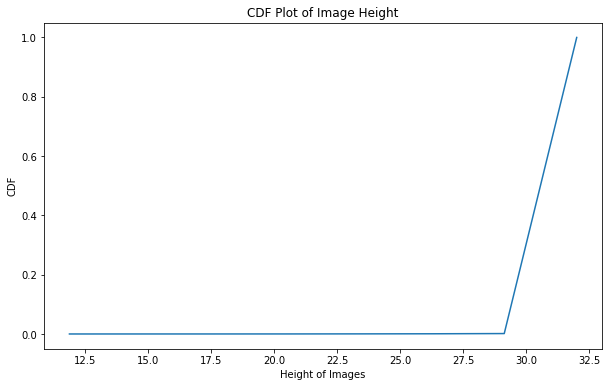

In [33]:
cdf_image_heights(train_img_size['Height'].values)

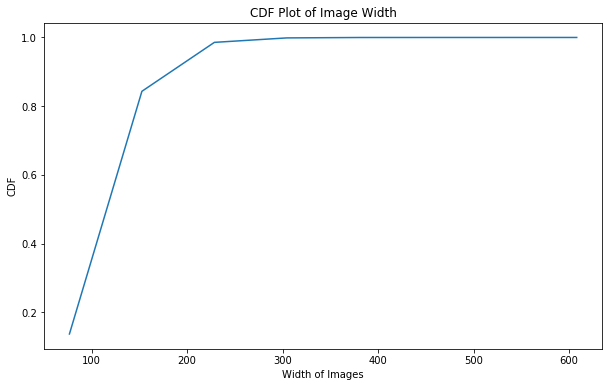

In [34]:
cdf_image_widths(train_img_size['Width'].values)

**Observation**
1. Most of the Images have a height of 31
2. Almost 95% of the Images have a height of 200 or less

**Validation Data Height and Width CDF Plots**

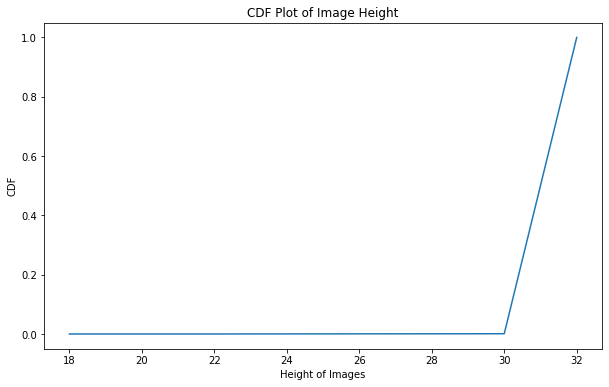

In [36]:
cdf_image_heights(val_img_size['Height'].values)

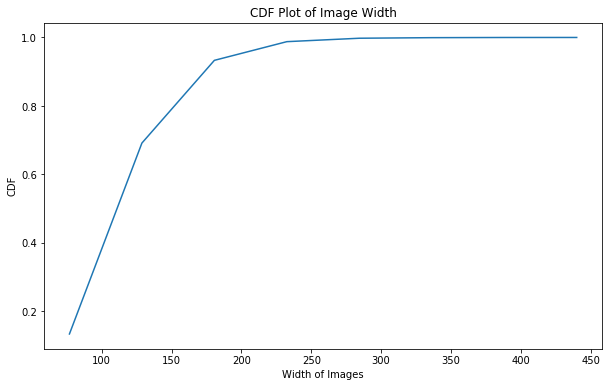

In [37]:
cdf_image_widths(val_img_size['Width'].values)

**Observation**
1. Most of the Images have a height of 31
2. Almost 95% of the Images have a height of 200 or less

**Test Data Height and Width CDF Plots**

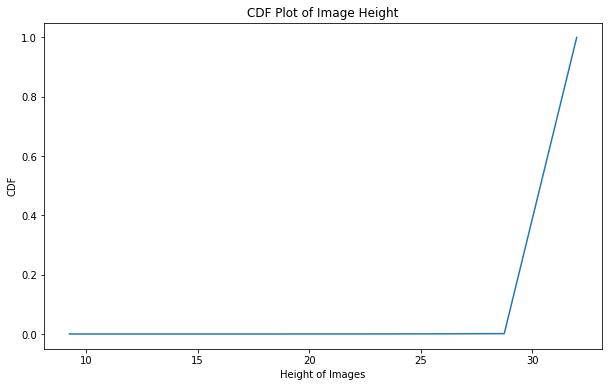

In [38]:
cdf_image_heights(test_img_size['Height'].values)

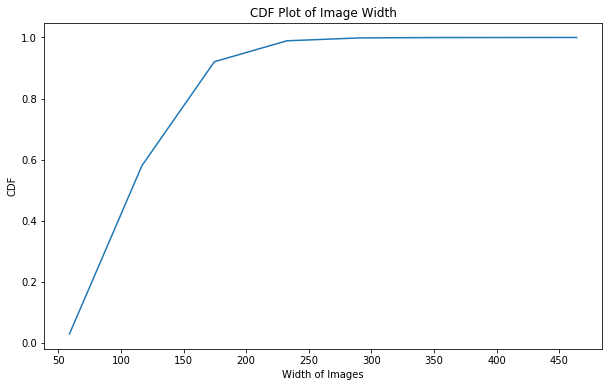

In [39]:
cdf_image_widths(test_img_size['Width'].values)

**Observation**
1. Most of the Images have a height of 31
2. Almost 95% of the Images have a height of 200 or less

**Conclusion**
1. Most of the Images have a Height of 31
2. Almost 95 % of the Images have a width of 200 or less
3. Based on these observations we can resize the images to 32 (Height) x 170 (Width)

### 7.2. Label Data Analysis

In [32]:
def pdf_label_lengths(label_len):
    """
    Takes a list of label lengths as input and Plots PDF of lengths of Labels
    """
    plt.figure(figsize=(10,6))
    count_labels=np.array(label_len)
    counts, bin_edges = np.histogram(count_labels, bins=8, 
                                 density = True)
    pdf = counts/(sum(counts))
    plt.plot(bin_edges[1:],pdf)
    plt.xlabel('Length of Labels',fontsize=10)
    plt.ylabel('PDF',fontsize=10)
    plt.title('PDF Plot of lengths of Labels',fontsize=12)
    #Last Element after sorting contains maximum of lengths in labels
    max_len=max(label_len)
    plt.show()
    print('-'*100)
    print('Maximum Length of Label: ',max_len)
    print('-'*100)

In [33]:
def cdf_label_lengths(label_len):
    """
    Takes a list of label lengths as input and Plots CDF of lengths of Labels
    """
    plt.figure(figsize=(10,6))
    count_labels=np.array(label_len)
    counts, bin_edges = np.histogram(count_labels, bins=8, 
                                 density = True)
    pdf = counts/(sum(counts))
    cdf=np.cumsum(pdf)
    plt.plot(bin_edges[1:],cdf)
    plt.xlabel('Length of Labels',fontsize=10)
    plt.ylabel('CDF',fontsize=10)
    plt.title('CDF Plot of lengths of Labels',fontsize=12)
    plt.show()

In [34]:
def top_5_lengths_percentage(label_len,counts,total):
    """
    Takes Top 5 Label lengths, their respective counts , total length of labels and computes their percentages
    and plots a bar graph with percentage of top 5 label lengths present in the data
    """
    plt.figure(figsize=(10,6))
    indices=np.arange(len(label_len))
    counts=np.array(counts)
    percent=(counts/total)*100
    plt.bar(indices,percent)
    plt.xlabel('Label Lengths',fontsize=10)
    plt.ylabel('Percentages',fontsize=10)
    plt.title('Percentages of Top 5 lengths of Labels',fontsize=12)
    plt.xticks(indices,label_len)
    plt.show()    

In [35]:
# https://stackoverflow.com/questions/19859282/check-if-a-string-contains-a-number
import re
def hasDigits(inputText):
    """
    Returns True if the given input text has digits in it otherwise returns False
    """
    return bool(re.search(r'\d', inputText))

In [36]:
def digit_count(labels,size):
    """
    Takes the list of labels and counts the number of labels with and without digits
    and prints its percentage
    """
    present=0
    absent=0
    for i in labels:
        pres=hasDigits(i)
        if pres==True:
            present+=1
        else:
            absent+=1
    present_percent=(present/size)*100
    absent_percent=(absent/size)*100
    print('Labels with Digits: ',present_percent,' %')
    print('Labels without Digits: ',absent_percent,' %')        

#### 7.2.1. Train Data

In [2]:
train_data=pd.read_csv('Train_data.csv')

In [3]:
train_data.drop(['Unnamed: 0'],axis=1,inplace=True)

In [4]:
train_label_len=[len(str(x)) for x in train_data['Labels'].values]

In [30]:
#Saving the updated Train Dataframe
train_data.to_csv('Train_Final.csv')

In [42]:
from collections import Counter

In [41]:
train_label_len_dict=Counter(train_label_len)

In [42]:
#Printing Value counts of Label Lengths 
train_label_len_dict

Counter({4: 9160,
         10: 23919,
         9: 30503,
         8: 34304,
         5: 16790,
         6: 25596,
         12: 9877,
         7: 33812,
         11: 16036,
         3: 3})

In [43]:
# https://stackoverflow.com/questions/20944483/python-3-sort-a-dict-by-its-values
#Sorting dict by value in decending order and storing keys
train_keys = [k for k in sorted(train_label_len_dict, key=train_label_len_dict.get, reverse=True)]

In [44]:
#Taking Top 5 keys with highest values 
train_top_keys=train_keys[:5]
train_top_values=[train_label_len_dict.get(k) for k in train_top_keys]

**Train Data Label Lengths PDF**

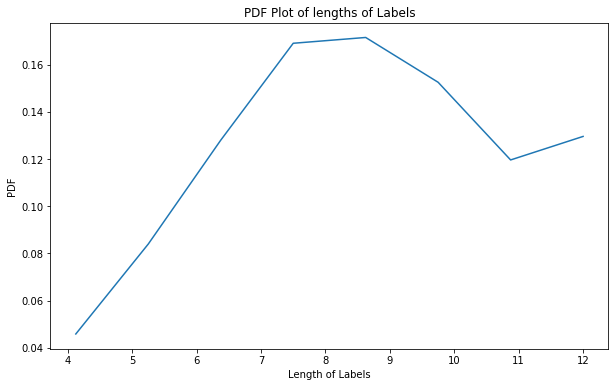

----------------------------------------------------------------------------------------------------
Maximum Length of Label:  12
----------------------------------------------------------------------------------------------------


In [45]:
pdf_label_lengths(train_label_len)

**Observations:**
1. Most of the Labels have lengths of 7,8 and 9 in Train Data
2. Labels of length 4, 5 and 6 are fewer in number
3. Higher length Labels are more in number compared to lower length labels

**Train Data Label Lengths CDF Plot**

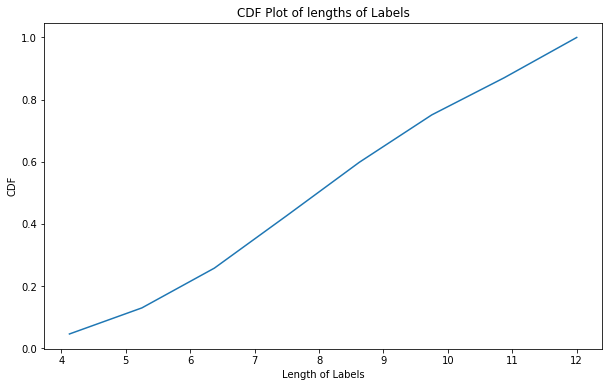

In [46]:
cdf_label_lengths(train_label_len)

**Observations:**
1. Almost 60% of the Labels have length 9 or less
2. There are 20% of the Labels which have length of 6 or less

**Train Data Top 5 Label Lengths Count(%) Bar Graph**

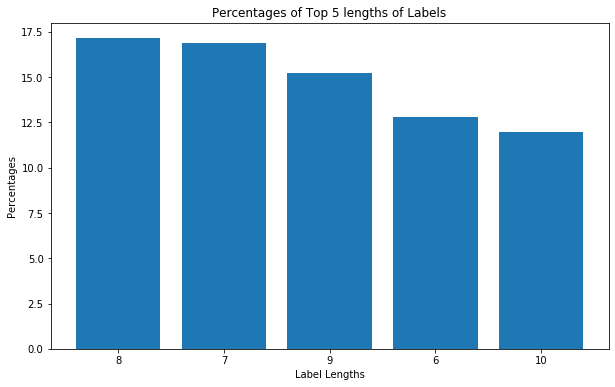

In [47]:
top_5_lengths_percentage(train_top_keys,train_top_values,len(train_label_len))

**Observations:**
1. There are almost equal number of labels with length 8 and 7 comprising of 17% each of total number of labels of different lengths in Train Data
2. Labels of length 9 comprise 15% of total number of labels of different lengths in Train Data 
3. Labels of length 6 and 10 are almost equal comprising 12.5% of Total number of labels 

**Train Data Digit Presence Percentage**

In [48]:
train_labels=[str(x) for x in train_data['Labels'].values]
digit_count(train_labels,len(train_labels))

Labels with Digits:  0.07050000000000001  %
Labels without Digits:  99.9295  %


**Observations:**
1. Almost all of the Labels in the Train Data do not have digits present in them comprising 99.925% of total data
2. Very Few labels in Train Data have digits present with a very less percentage of 0.0705% of total data

#### 7.2.2. Validation Data

In [4]:
val_data=pd.read_csv('Validation_data.csv')

In [5]:
val_data.drop(['Unnamed: 0'],axis=1,inplace=True)

In [8]:
val_label_len=[len(str(x)) for x in val_data['Labels'].values]

In [35]:
val_label_len_dict=Counter(val_label_len)

In [36]:
#Printing Value counts of Label Lengths 
val_label_len_dict

Counter({7: 2078,
         9: 1817,
         11: 942,
         10: 1525,
         8: 1944,
         5: 1002,
         12: 619,
         6: 1584,
         4: 489})

In [37]:
# https://stackoverflow.com/questions/20944483/python-3-sort-a-dict-by-its-values
#Sorting dict by value in decending order and storing keys
val_keys = [k for k in sorted(val_label_len_dict, key=val_label_len_dict.get, reverse=True)]

In [38]:
#Taking Top 5 keys with highest values 
val_top_keys=val_keys[:5]
val_top_values=[val_label_len_dict.get(k) for k in val_top_keys]

**Validation Data Label Lengths PDF**

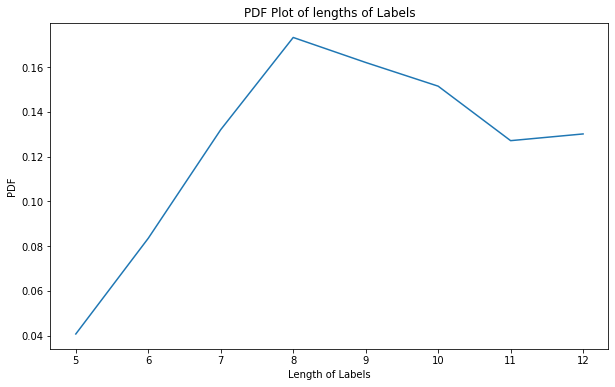

----------------------------------------------------------------------------------------------------
Maximum Length of Label:  12
----------------------------------------------------------------------------------------------------


In [75]:
pdf_label_lengths(val_label_len)

**Observations:**
1. Labels of Length 8,9 are the highest in number among all other Labels in Validation Data
2. Labels of Length 11, 12 are almost equal in number in Validation Data
3. Labels of Length 6 or less are very few

**Validation Data Label Lengths CDF**

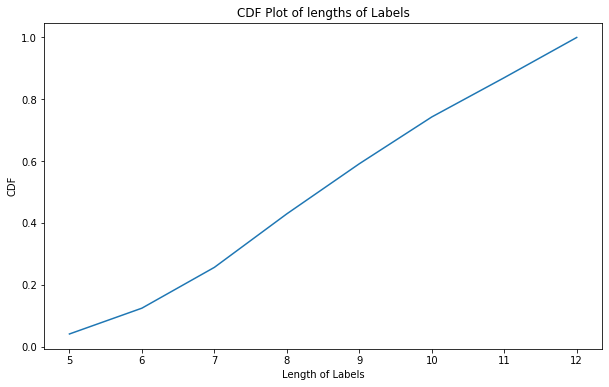

In [76]:
cdf_label_lengths(val_label_len)

**Observations:**
1. Almost 60 % of the Labels have length less than or equal to 9
2. There is an almost steep increase in CDF between length 6 to 8, meaning there are more number of labels with length in this range in Validation Data
3. There are very few labels with length less 6 comprising less than 20% of total labels in Validation Data

**Validation Data Top 5 Label Lengths Count(%) Bar Graph**

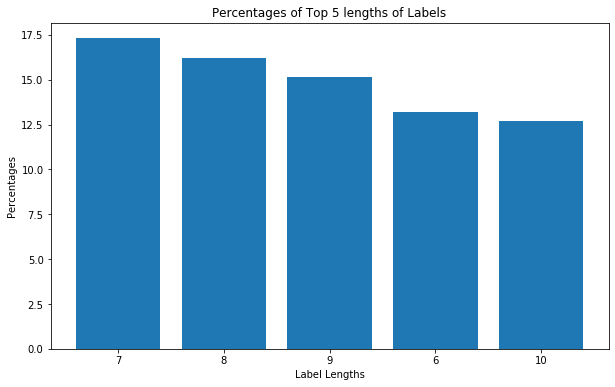

In [49]:
top_5_lengths_percentage(val_top_keys,val_top_values,len(val_label_len))

**Observations:**
1. Highest number of labels in Validation Data are of length 7 comprising almost 17.5% of total validation data labels
2. Labels of Length 6 and 10 are almost equal in number comprising almost 12.5% each of total data

**Validation Data Digit Presence Percentage**

In [51]:
val_labels=[str(x) for x in val_data['Labels'].values]
digit_count(val_labels,len(val_labels))

Labels with Digits:  0.09166666666666666  %
Labels without Digits:  99.90833333333333  %


**Observations:**
1. Most of Labels found in Vlaidation Data do not have digits present in them with a percentage as high as 99.90% of total data
2. On the other hand the percentage of labels with digit is 0.091 % of total data, which is very less 

#### 7.2.3. Test Data

In [82]:
test_data=pd.read_csv('Test_data.csv')

In [83]:
test_data.drop(['Unnamed: 0'],axis=1,inplace=True)

In [11]:
test_label_len=[len(str(x)) for x in test_data['Labels'].values]

In [55]:
test_label_len_dict=Counter(test_label_len)

In [58]:
#Printing Value counts of Label Lengths 
test_label_len_dict

Counter({8: 2490,
         10: 1742,
         12: 730,
         5: 1317,
         9: 2271,
         11: 1255,
         7: 2495,
         6: 1990,
         4: 710})

In [59]:
# https://stackoverflow.com/questions/20944483/python-3-sort-a-dict-by-its-values
#Sorting dict by value in decending order and storing keys
test_keys = [k for k in sorted(test_label_len_dict, key=test_label_len_dict.get, reverse=True)]

In [60]:
#Taking Top 5 keys with highest values 
test_top_keys=test_keys[:5]
test_top_values=[test_label_len_dict.get(k) for k in test_top_keys]

**Test Data Label Lengths PDF**

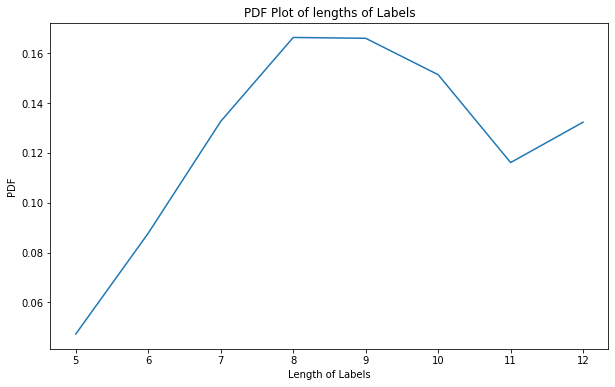

----------------------------------------------------------------------------------------------------
Maximum Length of Label:  12
----------------------------------------------------------------------------------------------------


In [77]:
pdf_label_lengths(test_label_len)

**Observations:**
1. Most of the Labels in Test Data have lengths 8,9 and 10
2. Labels with length less than 7 are very less compared to labels of other lengths in Test Data

**Test Data Label Lengths CDF**

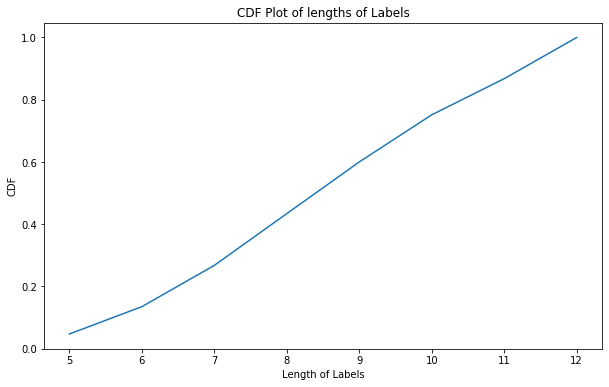

In [78]:
cdf_label_lengths(test_label_len)

**Observations:**
1. Almost 60% of the Labels have length less than 9 in Test Data
2. Very less number of labels have length less than 6 comprising less than 20% of all Test Data

**Test Data Top 5 Label Lengths Count(%) Bar Graph**

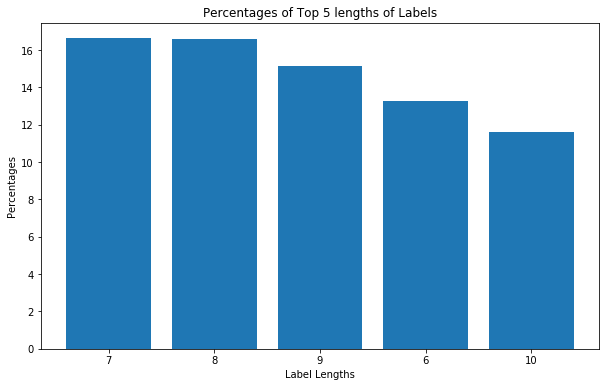

In [62]:
top_5_lengths_percentage(test_top_keys,test_top_values,len(test_label_len))

**Observations:**
1. Highest number of Labels in Test Data have lengths 7 and 8 comprising more than 16% each of the Total Test Data
2. Top 5 Label lengths in Test Data are between 6 and 10 both inclusive

**Test Data Digit Presence Percentage**

In [63]:
test_labels=[str(x) for x in test_data['Labels'].values]
digit_count(test_labels,len(test_labels))

Labels with Digits:  0.08666666666666667  %
Labels without Digits:  99.91333333333333  %


**Observations:**
1. Almost all of the Labels in the Test Data do not have digits present in them comprising 99.91% of total data
2. Very Few labels in Test Data have digits present with a very less percentage of 0.086% of total data

**Label Letters Data Analysis**

In [150]:
train_data=pd.read_csv('Train_Final.csv')
val_data=pd.read_csv('Validation_Final.csv')
test_data=pd.read_csv('Test_Final.csv')

In [151]:
letters='ABCDEFGHIJKLMNOPQRSTUVWXYZ'
train_labels_combined=' '.join([str(x) for x in train_data['Labels'].values])
val_labels_combined=' '.join([str(x) for x in val_data['Labels'].values])
test_labels_combined=' '.join([str(x) for x in test_data['Labels'].values])

In [152]:
def letters_list(letter,combined_labels):
    """
    Takes the letters, combined labels text checks for the presence of each letter and returns a list of letters 
    present in the combined labels
    """
    letter_list=[]
    for i in range(len(letter)):
        if letter[i] in combined_labels:
            letter_list.append(letter[i])
    return letter_list

In [153]:
train_letter_set=set(letters_list(letters,train_labels_combined))
val_letter_set=set(letters_list(letters,val_labels_combined))
test_letter_set=set(letters_list(letters,test_labels_combined))

In [154]:
print("Number of unique Letters in Train Data: ",len(train_letter_set))
print("Number of unique Letters in Validation Data: ",len(val_letter_set))
print("Number of unique Letters in Test Data: ",len(test_letter_set))

Number of unique Letters in Train Data:  26
Number of unique Letters in Validation Data:  26
Number of unique Letters in Test Data:  26


**Observation**
All Letters in the alphabet are present in each of Train, Validation and Test Data

#### Label Data Analysis Summary

1. All of the Top 5 Label lengths present in Train, Validation and Test Data are same with Top 5 Label lengths being **7,8,9,6,10**
2. The Distribution of Data in the Digit Presence in Labels perspective is uniform across Train, Validation and Test Data, each comprising almost **99%** of Labels without digits in them
3. Top 2 Label Lengths are **7 , 8** across Train, Validation and Test Data
4. These Factors ensure that some properties related to Labels in each of Train, Validation and Test Data are same and uniform

### 7.3. Conclusions from Data Analysis

1. Most of the Images around 90 % have height 32 and width less than 170
2. Most of the Labels present have lengths 7,8 and 9
3. Based on this we can re-size the images to 32 (Height) X 170 (Width)

## 8. Utility Functions

In [6]:
import keras
import random
from keras import backend as K
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [7]:
#Letters present in the Label Text
letters= '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [8]:
#image height
img_h=32
#image width
img_w=170
#image Channels
img_c=1
# classes for softmax with number of letters +1 for blank space in ctc
num_classes=len(letters)+1
batch_size=64
max_length=15 # considering max length of ground truths labels to be 15

In [9]:
def encode_words_labels(word):
    """
    Encodes the Ground Truth Labels to a list of Values like eg.HAT returns [17,10,29]
    """
    label_lst=[]
    for char in word:
        label_lst.append(letters.find(char)) # keeping 0 for blank and for padding labels
    return label_lst

In [10]:
def words_from_labels(labels):
    """
    converts the list of encoded integer labels to word strings like eg. [12,10,29] returns CAT 
    """
    txt=[]
    for ele in labels:
        if ele == len(letters): # CTC blank space
            txt.append("")
        else:
            #print(letters[ele])
            txt.append(letters[ele])
    return "".join(txt)

In [11]:
def ctc_loss_function(args):
    """
    CTC loss function takes the values passed from the model returns the CTC loss using Keras Backend ctc_batch_cost function
    """
    y_pred, y_true, input_length, label_length = args 
    # since the first couple outputs of the RNN tend to be garbage we need to discard them, found this from other CRNN approaches
    # I Tried by including these outputs but the results turned out to be very bad and got very low accuracies on prediction 
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(y_true, y_pred, input_length, label_length)   

## 9. Data Generation

Since the CTC loss fuction computed using Keras Backend ctc_batch_cost function requires 4 inputs, we build a **Data genearator class** and define the parameters for our input image and also process the 4 inputs which needs to be passed to the model for computing CTC loss

In [14]:
#https://github.com/qjadud1994/CRNN-Keras
#https://keras.io/examples/image_ocr/

class DataGenerator(keras.callbacks.Callback):
    def __init__(self, img_dirpath, img_w, img_h,
                 batch_size,n,output_labels,max_text_len=15):
        self.img_h = img_h                    #Image Height
        self.img_w = img_w                    #Image Width
        self.batch_size = batch_size          #Batch size of Input
        self.max_text_len = max_text_len      #Maximum Text length of Labels
        
#         self.n =len(self.img_dir)                           #Number of images in img_matrix
        self.n=n
        self.img_dir = img_dirpath[:self.n]     # images list
        self.indexes = list(range(self.n))   #List of indices for each image in img_matrix
        self.cur_index = 0                   #Current index which points to image being loaded 
        self.imgs = np.zeros((self.n, self.img_h, self.img_w))
        self.texts =  output_labels[:self.n]                  #List of Ground Truth Label texts

   
    def build_data(self):
        """
        Build The Image Data
        """
        print(self.n, " Image Loading start...")
        for i, img_file in enumerate(self.img_dir):
            img = cv2.imread(img_file)
            img = img[:,:,1]                               #Extracting Single Channel Image
            img = cv2.resize(img, (self.img_w, self.img_h))
            img = img /255
            self.imgs[i, :, :]= img
            if i%10000==0:
                print("Loaded Images: ",i)
           
        print("Number of Texts matches with Total Number of Images :",len(self.texts) == self.n)
        print(self.n, " Image Loading finish...")


    def next_data(self): 
        """
        Returns image and text data pointed by the current index
        """
        self.cur_index += 1
        #If current index becomes more than the number of images, make current index 0 
        #and shuffle the indices list for random picking of image and text data
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indexes)
        return self.imgs[self.indexes[self.cur_index]], self.texts[self.indexes[self.cur_index]]

    def next_batch(self):
        """
        Creates a batch of images images and text data equal to the batch_size,
        computes the parameters needed for CTC and returns the inputs to the Model
        """
        while True:
            X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])  #Single channel Gray Size Scale images for input
            #Initilizing with -1 to aid for padding labels of different lengths
            Y_data = np.ones([self.batch_size, self.max_text_len])* -1        #Text labels for input
           #input_length for CTC which is the number of time-steps of the RNN output
            input_length = np.ones((self.batch_size, 1)) * 40
            label_length = np.zeros((self.batch_size, 1))                   #label length for CTC
            source_str=[]                                                   #List to store Ground Truth Labels
            for i in range(self.batch_size):
                img, text = self.next_data() #getting the image and text data pointed by current index
                                    #taking transpose of image
                img=img.T
                img = np.expand_dims(img, -1)  #expanding image to have a single channel
                X_data[i] = img
                label=encode_words_labels(text) # encoding label text to integer list and storing in temp label variable
                lbl_len=len(label)
                Y_data[i,0:lbl_len] = label #Storing the label till its length and padding others
                label_length[i] = len(label)
                source_str.append(text) #storing Ground Truth Labels which will be accessed as reference for calculating metrics
            
        #Preparing the input for the Model
            inputs = {
                'img_input': X_data,  
                'ground_truth_labels': Y_data,  
                'input_length': input_length,  
                'label_length': label_length,
                'source_str': source_str  # used for visualization only
            }
            #Preparing output for the Model and intializing to zeros
            outputs = {'ctc': np.zeros([self.batch_size])}  
            yield (inputs, outputs) # Return the Prepared input and output to the Model

## 10. Overview of Model

**Below is the Representation of Model Overview presented in the Research Paper**

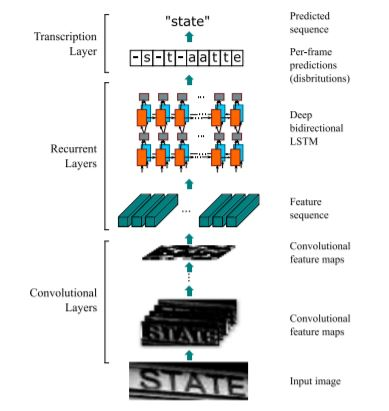

In [6]:
Image('model_overview.jpg')

**The architecture consists of three parts:**
1. convolutional layers, which extract a feature sequence from the input image; 
2. recurrentlayers, which predict a label distribution for each frame; 
3. transcription layer, which translates the per-frame predictions into the final label sequence

**Source: https://ieeexplore.ieee.org/abstract/document/7801919**

## 11. Model Architecture

**Below is the Model Architecture presented in the Research Paper which is implemented as a part of the Case Study for Scene Text Recognition Problem** 

**Source: https://ieeexplore.ieee.org/abstract/document/7801919**

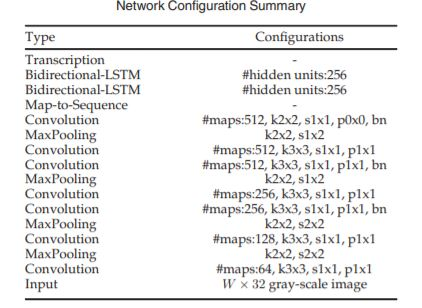

In [7]:
Image('model_architecture.jpg')

## 12. Model Implementation

In [16]:
from keras.layers import Input, Conv2D, MaxPool2D, Dense,MaxPooling2D
from keras.layers import AveragePooling2D, Flatten, Activation, Bidirectional
from keras.layers import BatchNormalization, Dropout
from keras.layers import Concatenate, Add, Multiply, Lambda
from keras.layers import UpSampling2D, Reshape
from keras.layers.merge import add,concatenate
from keras.layers import Reshape
from keras.models import Model
from keras.layers.recurrent import LSTM,GRU
import tensorflow as tf

## 12.1. Model 1

**Model with Bi-Directional LSTM units and Adam Optimizer**

The Model Architecture has 2 Stages:
1. **Train Stage:** which takes input image, text labels (encoded as integers), input length (time-steps length), label length and outputs CTC loss
2. **Prediction Stage:** which takes input image and outputs a matrix of dimesnions 48x37 where 48 is the number of time-steps of RNN and 37 is the length of letters + 1 character for ctc blank 

In [59]:
def Image_text_recogniser_model_1(stage,drop_out_rate=0.35):
    """
    Builds the model by taking in the stage variable which specifes the stage,
    if the stage is training: model takes inputs required for computing ctc_batch_cost function
    else : model takes input as images which is used for prediction
    """
    
    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_w, img_h)
    else:
        input_shape = (img_w, img_h, 1)
       
    model_input=Input(shape=input_shape,name='img_input',dtype='float32')

    # Convolution layer 
    model = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(model_input) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(2, 2), name='max1')(model) 

    model = Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(2, 2), name='max2')(model) 

    model = Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(model)
    model=Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(1, 2), name='max3')(model)  

    model = Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Conv2D(512, (3, 3), padding='same', name='conv6')(model)
    model=Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(1, 2), name='max4')(model) 

    model = Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(model)
    model=Dropout(0.25)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)    

    # CNN to RNN
    model = Reshape(target_shape=((42, 1024)), name='reshape')(model)  
    model = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(model)  

    # RNN layer
    model=Bidirectional(LSTM(256, return_sequences=True, kernel_initializer='he_normal'), merge_mode='sum')(model)
    model=Bidirectional(LSTM(256, return_sequences=True, kernel_initializer='he_normal'), merge_mode='concat')(model)

    # transforms RNN output to character activations:
    model = Dense(num_classes, kernel_initializer='he_normal',name='dense2')(model) 
    y_pred = Activation('softmax', name='softmax')(model)

    
    labels = Input(name='ground_truth_labels', shape=[max_length], dtype='float32') 
    input_length = Input(name='input_length', shape=[1], dtype='int64') 
    label_length = Input(name='label_length', shape=[1], dtype='int64') 

    #CTC loss function
    loss_out = Lambda(ctc_loss_function, output_shape=(1,),name='ctc')([y_pred, labels, input_length, label_length]) #(None, 1)

    if stage=='train':
        return model_input,y_pred,Model(inputs=[model_input, labels, input_length, label_length], outputs=loss_out)
    else:
        return Model(inputs=[model_input], outputs=y_pred)        

In [18]:
model_input,y_pred,img_text_recog=Image_text_recogniser_model_1('train')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [19]:
#used for visualization
# it is a keras backend function used to capture the model ouputs so that it can be used for decoding and calculating metrics
test_func = K.function([model_input], [y_pred])

In [20]:
img_text_recog.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          (None, 170, 32, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 170, 32, 64)  640         img_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 170, 32, 64)  256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 170, 32, 64)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max1 (MaxP

The Function Takes the final 40x37 output matrices from the model for the batch from test_func function, and takes the argmax of the matrix across each column (which returns a value between 0 to 36 (ctc_blank) both included). The outputs are then merged for repeated values and gives a list of integers. The Final output integers is then converted to final output string text and stored in a list. The Final List containing all decoded outputs are returened by the function

In [12]:
def decode_batch(test_func, word_batch):
    """
    Takes the Batch of Predictions and decodes the Predictions by Best Path Decoding and Returns the Output
    """
    out = test_func([word_batch])[0] #returns the predicted output matrix of the model
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = words_from_labels(out_best)
        ret.append(outstr)
    return ret

In [105]:
def accuracies(actual_labels,predicted_labels,is_train):
    """
    Takes a List of Actual Outputs, predicted Outputs and returns their accuracy and letter accuracy across
    all the labels in the list
    """
    accuracy=0
    letter_acc=0
    letter_cnt=0
    count=0
    for i in range(len(actual_labels)):
        predicted_output=predicted_labels[i]
        actual_output=actual_labels[i]
        count+=1
        for j in range(min(len(predicted_output),len(actual_output))):
            if predicted_output[j]==actual_output[j]:
                letter_acc+=1
        letter_cnt+=max(len(predicted_output),len(actual_output))
        if actual_output==predicted_output:
            accuracy+=1
    final_accuracy=np.round((accuracy/len(actual_labels))*100,2)
    final_letter_acc=np.round((letter_acc/letter_cnt)*100,2)
    return final_accuracy,final_letter_acc

**CallBacks**

In [15]:
#https://keras.io/examples/image_ocr/
class VizCallback(keras.callbacks.Callback):
    """
    The Custom Callback created for printing the Accuracy and Letter Accuracy Metrics at the End of Each Epoch
    """

    def __init__(self, test_func, text_img_gen,is_train,acc_compute_batches):
        self.test_func = test_func
        self.text_img_gen = text_img_gen
        self.is_train=is_train                #used to indicate whether the callback is called to for Train or Validation Data
        self.acc_batches=acc_compute_batches  # Number of Batches for which the metrics are computed typically equal to steps/epoch

    def show_accuracy_metrics(self,num_batches):
        """
        Calculates the accuracy and letter accuracy for each batch of inputs, 
        and prints the avarage accuracy and letter accuracy across all the batches
        """
        accuracy=0
        letter_accuracy=0
        batches_cnt=num_batches
        while batches_cnt>0:
            word_batch = next(self.text_img_gen)[0]   #Gets the next batch from the Data generator
            decoded_res = decode_batch(self.test_func,word_batch['img_input'])
            actual_res=word_batch['source_str']
            acc,let_acc=accuracies(actual_res,decoded_res,self.is_train)
            accuracy+=acc
            letter_accuracy+=let_acc
            batches_cnt-=1
        accuracy=accuracy/num_batches
        letter_accuracy=letter_accuracy/num_batches
        if self.is_train:
            print("Train Average Accuracy of "+str(num_batches)+" Batches: ",np.round(accuracy,2)," %")
            print("Train Average Letter Accuracy of "+str(num_batches)+" Batches: ",np.round(letter_accuracy,2)," %")
        else:
            print("Validation Average Accuracy of "+str(num_batches)+" Batches: ",np.round(accuracy,2)," %")
            print("Validation Average Letter Accuracy of "+str(num_batches)+" Batches: ",np.round(letter_accuracy,2)," %")
            
        
    def on_epoch_end(self, epoch, logs={}):
        self.show_accuracy_metrics(self.acc_batches)
        

In [17]:
%load_ext tensorboard.notebook

In [18]:
import datetime

In [19]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
early_stop=EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True)
model_chk_pt=ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=False,save_weights_only=True,verbose=0, mode='auto', period=2)

In [20]:
logdir = os.path.join("logs_127", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [21]:
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [22]:
%tensorboard --logdir logs_127

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 19124.

**Labels Loading**

In [23]:
#Loading Train Data Labels
Train_labels=[str(x) for x in train_data['Labels'].values]

In [24]:
train_paths=[str(x) for x in train_data['ImageName'].values]

In [25]:
train_nan_cnt=0
train_nan_replaced=False
for i in range(len(Train_labels)):
    if Train_labels[i]=='nan':
        Train_labels[i]='NULL'
        train_nan_replaced=True
        train_nan_cnt+=1

In [26]:
print('Was there any NULL values written as Nan in Train Data:',train_nan_replaced)
print('Train Nan count: ',train_nan_cnt)

Was there any NULL values written as Nan in Train Data: True
Train Nan count:  3


In [27]:
#Loading Validation Data Labels
cv_labels=[str(x) for x in val_data['Labels'].values]

In [28]:
val_path=[str(x) for x in val_data['ImageName'].values]

In [29]:
val_nan_cnt=0
val_nan_replaced=False
for i in range(len(cv_labels)):
    if cv_labels[i]=='nan':
        cv_labels[i]='NULL'
        val_nan_replaced=True
        val_nan_cnt+=1

In [30]:
print('Was there any NULL values written as Nan :',val_nan_replaced)
print('Validation Nan count: ',val_nan_cnt)

Was there any NULL values written as Nan : False
Validation Nan count:  0


**Instatiating Data Generator**

In [31]:
train_gene=DataGenerator(train_paths,img_w, img_h,batch_size,200000,Train_labels)

In [32]:
train_gene.build_data()

200000  Image Loading start...
Loaded Images:  0
Loaded Images:  10000
Loaded Images:  20000
Loaded Images:  30000
Loaded Images:  40000
Loaded Images:  50000
Loaded Images:  60000
Loaded Images:  70000
Loaded Images:  80000
Loaded Images:  90000
Loaded Images:  100000
Loaded Images:  110000
Loaded Images:  120000
Loaded Images:  130000
Loaded Images:  140000
Loaded Images:  150000
Loaded Images:  160000
Loaded Images:  170000
Loaded Images:  180000
Loaded Images:  190000
Number of Texts matches with Total Number of Images : True
200000  Image Loading finish...


In [33]:
train_num_batches=int(train_gene.n / batch_size)

In [36]:
viz_cb_train = VizCallback( test_func, train_gene.next_batch(),True,train_num_batches)

In [37]:
val_gen=DataGenerator(val_path,img_w, img_h,batch_size,12000,cv_labels)

In [38]:
val_gen.build_data()

12000  Image Loading start...
Loaded Images:  0
Loaded Images:  10000
Number of Texts matches with Total Number of Images : True
12000  Image Loading finish...


In [39]:
val_num_batches=int(val_gen.n / batch_size)

In [42]:
viz_cb_val = VizCallback( test_func, val_gen.next_batch(),False,val_num_batches)

**Defining Optimizer**

In [43]:
from keras import optimizers
adam=optimizers.Adam()

In the Keras functionnal API, we can define, train and use a neural network using the Model class. The loss functions that can be used in a class Model have only 2 arguments, the ground truth y_true and the prediction y_pred given in output of the neural network. At present, there is no CTC loss proposed in a Keras Model and, Keras doesn’t currently support loss functions with extra parameters, which is the case for a CTC loss that requires sequence lengths for batch training. Indeed, as observation and label sequences are of variable length, one has to provide the length of each sequence (observation and label), which allows to not consider padding in the loss computation

In [44]:
#Creating a Dummy Loss function as in Keras there is no CTC loss implementation which actually takes 4 inputs 
#The loss function in keras accepts only 2 inputs, so create a dummy loss which is a work around for implementing CTC in Keras
#The Actual loss computation happens in ctc_loss_function defined above
img_text_recog.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=adam)

### 12.1.1. Train Model 1

In [45]:
img_text_recog.fit_generator(generator=train_gene.next_batch(),
                    steps_per_epoch=int(train_gene.n / batch_size),
                    epochs=20,
                    callbacks=[viz_cb_train,viz_cb_val,train_gene,val_gen,tensorboard_callback,early_stop,model_chk_pt],
                    validation_data=val_gen.next_batch(),
                    validation_steps=int(val_gen.n / batch_size))
#callbacks=[viz_cb_train,viz_cb_val,train_gene,val_gen,tensorboard_callback,early_stop,model_chk_pt],

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/20
3125/3125 [==============================] - 1374s 440ms/step - loss: 7.4525 - val_loss: 2.5121
Train Average Accuracy of 3125 Batches:  71.41  %
Train Average Letter Accuracy of 3125 Batches:  86.54  %
Validation Average Accuracy of 187 Batches:  70.58  %
Validation Average Letter Accuracy of 187 Batches:  85.85  %
Epoch 2/20
3125/3125 [==============================] - 1373s 439ms/step - loss: 2.0493 - val_loss: 1.8957
Train Average Accuracy of 3125 Batches:  78.35  %
Train Average Letter Accuracy of 3125 Batches:  90.04  %
Validation Average Accuracy of 187 Batches:  76.81  %
Validation Average Letter Accuracy of 187 Batches:  89.03  %
Epoch 3/20
3125/3125 [==============================] - 1370s 438ms/step - loss: 1.6298 - val_loss: 1.5248
Train Average Accuracy of 3125 Batches:  82.74  %
Train Average Letter Accuracy of 3125 Batches:  92.66  %
Validation Average Accuracy of 187 Batches:  81.07

In [46]:
img_text_recog.save('Best_Img_recog_LSTM_Adam_model_run_weights.h5')

In [48]:
img_text_recog.save('Img_recog_LSTM_Adam_model_run_3.h5')

**Train CTC Loss Plot**

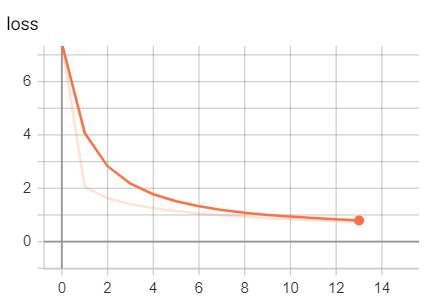

In [49]:
Image('LSTM_Model_Train_Loss_Plot.jpg')

**Validation CTC Loss Plot**

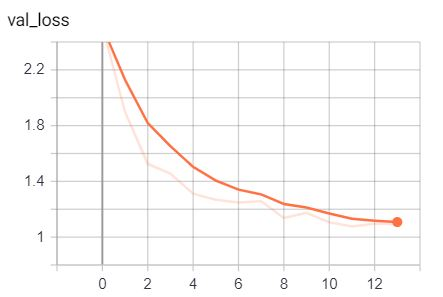

In [50]:
Image('LSTM_Model_Val_loss_Plot.jpg')

## 12.2. Model 2

**Model with Bi-Directional GRU units and RAdam Optimizer**

Since GRU is also RNN with faster training time than LSTM, Creating the same architecture with Bi-directional GRU units and RAdam Optimizer to observe if this model architecture gives better results than the previous model

The Model Architecture has 2 Stages:
1. **Train Stage:** which takes input image, text labels (encoded as integers), input length (time-steps length), label length and outputs CTC loss
2. **Prediction Stage:** which takes input image and outputs a matrix of dimesnions 48x37 where 48 is the number of time-steps of RNN and 37 is the length of letters + 1 character for ctc blank 

In [40]:
def Image_text_recogniser_model_2(stage,drop_out_rate=0.35):
    """
    Builds the model by taking in the stage variable which specifes the stage,
    if the stage is training: model takes inputs required for computing ctc_batch_cost function
    else : model takes input as images which is used for prediction
    """
    
    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_w, img_h)
    else:
        input_shape = (img_w, img_h, 1)
       
    model_input=Input(shape=input_shape,name='img_input',dtype='float32')

    # Convolution layer 
    model = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(model_input) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(2, 2), name='max1')(model) 

    model = Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(2, 2), name='max2')(model) 

    model = Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(model)
    model=Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(1, 2), name='max3')(model)  

    model = Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(model) 
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Conv2D(512, (3, 3), padding='same', name='conv6')(model)
    model=Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(1, 2), name='max4')(model) 

    model = Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(model)
    model=Dropout(0.25)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
#     print(model.shape)
    

    # CNN to RNN
    model = Reshape(target_shape=((42, 1024)), name='reshape')(model)  
    model = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(model)  

    # RNN layer
    model=Bidirectional(GRU(256, return_sequences=True, kernel_initializer='he_normal'), merge_mode='sum')(model)
    model=Bidirectional(GRU(256, return_sequences=True, kernel_initializer='he_normal'), merge_mode='concat')(model)

    # transforms RNN output to character activations:
    model = Dense(num_classes, kernel_initializer='he_normal',name='dense2')(model) 
    y_pred = Activation('softmax', name='softmax')(model)

    
    labels = Input(name='ground_truth_labels', shape=[max_length], dtype='float32') 
    input_length = Input(name='input_length', shape=[1], dtype='int64') 
    label_length = Input(name='label_length', shape=[1], dtype='int64') 

    #CTC loss function
    loss_out = Lambda(ctc_loss_function, output_shape=(1,),name='ctc')([y_pred, labels, input_length, label_length]) #(None, 1)

    if stage=='train':
        return model_input,y_pred,Model(inputs=[model_input, labels, input_length, label_length], outputs=loss_out)
    else:
        return Model(inputs=[model_input], outputs=y_pred)        

In [41]:
model_input,y_pred,img_text_recog=Image_text_recogniser_model_2('train')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [42]:
 #used for visualization
test_func = K.function([model_input], [y_pred])

In [43]:
img_text_recog.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          (None, 170, 32, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 170, 32, 64)  640         img_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 170, 32, 64)  256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 170, 32, 64)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max1 (MaxP

In [44]:
viz_cb_train = VizCallback( test_func, train_gene.next_batch(),True,train_num_batches)

In [45]:
viz_cb_val = VizCallback( test_func, val_gen.next_batch(),False,val_num_batches)

**Defining RAdam Optimizer**

While Reading Articles on Medium Blog, I came across an article on a New State of the Art Optimizer, Rectified Adam (RAdam). I wanted to try it out and see the results compared to Adam optimizer. So I tried RAdam optimizer with exact same model architecture as the one used for Adam Optimizer.

In [46]:
#https://pypi.org/project/keras-radam/
from keras_radam import RAdam
Radam=RAdam()

In the Keras functionnal API, we can define, train and use a neural network using the Model class. The loss functions that can be used in a class Model have only 2 arguments, the ground truth y_true and the prediction y_pred given in output of the neural network. At present, there is no CTC loss proposed in a Keras Model and, Keras doesn’t currently support loss functions with extra parameters, which is the case for a CTC loss that requires sequence lengths for batch training. Indeed, as observation and label sequences are of variable length, one has to provide the length of each sequence (observation and label), which allows to not consider padding in the loss computation

In [47]:
#Creating a Dummy Loss function as in Keras there is no CTC loss implementation which actually takes 4 inputs 
#The loss function in keras accepts only 2 inputs, so create a dummy loss which is a work around for implementing CTC in Keras
#The Actual loss computation happens in ctc_loss_function defined above
img_text_recog.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Radam)

### 12.2.1. Train Model 2

In [49]:
img_text_recog.fit_generator(generator=train_gene.next_batch(),
                    steps_per_epoch=int(train_gene.n / batch_size),
                    epochs=20,
                    callbacks=[viz_cb_train,viz_cb_val,train_gene,val_gen,tensorboard_callback,early_stop,model_chk_pt],
                    validation_data=val_gen.next_batch(),
                    validation_steps=int(val_gen.n / batch_size))

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/20
3125/3125 [==============================] - 1275s 408ms/step - loss: 7.6903 - val_loss: 2.7829
Train Average Accuracy of 3125 Batches:  69.43  %
Train Average Letter Accuracy of 3125 Batches:  85.94  %
Validation Average Accuracy of 187 Batches:  69.02  %
Validation Average Letter Accuracy of 187 Batches:  85.77  %
Epoch 2/20
3125/3125 [==============================] - 1270s 406ms/step - loss: 2.2922 - val_loss: 2.2279
Train Average Accuracy of 3125 Batches:  75.64  %
Train Average Letter Accuracy of 3125 Batches:  89.35  %
Validation Average Accuracy of 187 Batches:  74.62  %
Validation Average Letter Accuracy of 187 Batches:  88.53  %
Epoch 3/20
3125/3125 [==============================] - 1272s 407ms/step - loss: 1.8783 - val_loss: 1.9426
Train Average Accuracy of 3125 Batches:  78.41  %
Train Average Letter Accuracy of 3125 Batches:  90.87  %
Validation Average Accuracy of 187 Batches:  77.21

In [50]:
img_text_recog.save('Best_Img_recog_GRU_RAdam_model_run_weights.h5')

**Model 2 Train CTC Loss Plot**

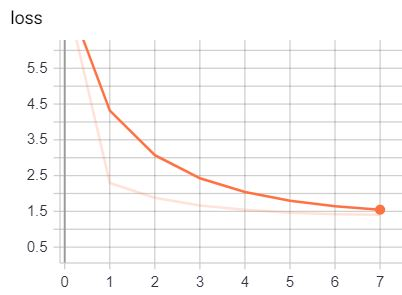

In [53]:
Image('GRU_Model_train_Loss_Plot.jpg')

**Model 2 Validation CTC Loss Plot**

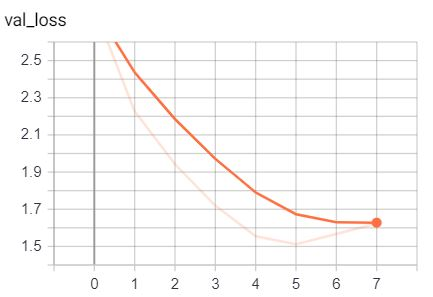

In [54]:
Image('GRU_Model_Val_Loss_Plot.jpg')

### Observations

1. Training Time for Model 2 lower than Model 1 
2. Train and Validation CTC loss for Model 1 is comparatively lower than the Train, Validation CTC loss for Model 2 after 50 epochs

## 13. Model Output Predictions

In [55]:
import itertools

### 13.1. Best Path Decoding 

The Function Takes the final 40x37 output matrix from the model, and takes the argmax of the matrix across each column (which returns a value between 0 to 36 (ctc_blank) both included). The outputs are then merged for repeated values and gives a list of integers. The Final output integers is then converted to final output string text and it is returned by the function

In [56]:
#https://keras.io/examples/image_ocr/
#https://github.com/qjadud1994/CRNN-Keras
def decode_label(out):
    """
    Takes the predicted ouput matrix from the Model and returns the output text for the image
    """
    # out : (1, 42, 37)
    # discarding first 2 outputs of RNN as they tend to be garbage 
    out_best = list(np.argmax(out[0,2:], axis=1))

    out_best = [k for k, g in itertools.groupby(out_best)]  # remove overlap value

    outstr=words_from_labels(out_best)
    return outstr

### 13.2. Test Output Prediction Function

The Function Takes in Following Inputs:
1. **model:** The Best Model obtained after training
2. **test_img_names:** The Image folder path where the input image is located
3. **test_labels:** The Ground Truth Text Labels of Corresponding input Images

<p> The function reads the images in the folder path and  resizes it to 32x100 dimension,single channel gray scale image.The processed image is passed to to best model which predicts the output which is a 1x48x37 matrix. The output Matrix is passed to CTC Best path decoding function which returns the predicted text word. The function then compares this predicted word text with the expected Ground truth Label and calculates Accuracy and Letter-Accuracy across the entire test data and returns accuracy, letter accuracy, letter count and letter mis match count.</p>

In [69]:
def test_data_output_Prediction(model,test_img_names,test_labels):
    """
    Takes the best model, test data image paths, test data groud truth labels and pre-processes the input image to 
    appropriate format for the model prediction, takes the predicted output matrix and uses best path decoding to 
    generate predicted text and compares with ground truth text for the input and ouputs the final accuracy,
    letter accuracy and  letter count across the entire test set of images, it also returns list of letter mis-match
    count for each test point in the whole test set of images
    """
    start=datetime.now()
    accuracy=0
    letter_acc=0
    letter_cnt=0
    count=0
    letter_mis_match=[]
    for i in range(len(test_labels)):
        test_img=cv2.imread(test_img_names[i])
        test_img_resized=cv2.resize(test_img,(170,32))
        test_image=test_img_resized[:,:,1]
        test_image=test_image.T
        test_image=np.expand_dims(test_image,axis=-1)
        test_image=np.expand_dims(test_image, axis=0)
        test_image=test_image/255
        model_output=model.predict(test_image)
        predicted_output=decode_label(model_output)
        actual_output=test_labels[i]
        count+=1
        mis_match=0
        for j in range(min(len(predicted_output),len(actual_output))):
            if predicted_output[j]==actual_output[j]:
                letter_acc+=1
            else:
                mis_match+=1
        letter_cnt+=max(len(predicted_output),len(actual_output))
        letter_mis_match.append(mis_match)
        if actual_output==predicted_output:
            accuracy+=1
        if (count%1000)==0:
            print("Processed ",count," Images")
    print("Time Taken for Processing: ",datetime.now()-start)
    return accuracy,letter_acc,letter_cnt,letter_mis_match

### 13.3. Model 1 Predictions

For Output Prediction, load the model achitecture  defined above for Predict stage which takes in the image as input and outputs a 48x37 matrix as ouput for each input image

In [60]:
model=Image_text_recogniser_model_1('predict')

The Best Weights for the Model are stored in BestLSTMModelWeights Folder, loading the stored best weights for Model 1 for prediction

In [62]:
model.load_weights('Final_LSTM_Model_Best_Weights/Best_Img_recog_LSTM_Adam_model_run_weights.h5')

**Synth Text Validation Data Prediction**

In [72]:
from datetime import datetime

In [70]:
val_img_names=val_data['ImageName'].values
val_labels=val_data['Labels'].values

In [73]:
synth_val_accuracy,synth_val_letter_acc,synth_val_letter_cnt,synth_val_mis_match=test_data_output_Prediction(model,val_img_names,val_labels)

Processed  1000  Images
Processed  2000  Images
Processed  3000  Images
Processed  4000  Images
Processed  5000  Images
Processed  6000  Images
Processed  7000  Images
Processed  8000  Images
Processed  9000  Images
Processed  10000  Images
Processed  11000  Images
Processed  12000  Images
Time Taken for Processing:  0:39:23.430397


In [74]:
print("Model Output Accuracy: ",(synth_val_accuracy/len(val_labels))*100, " %")
print("Model Output Letter Accuracy: ",(synth_val_letter_acc/synth_val_letter_cnt)*100, " %")

Model Output Accuracy:  86.47500000000001  %
Model Output Letter Accuracy:  94.01335219000873  %


In [76]:
from collections import Counter

In [77]:
model_1_val_mis_match_dict=Counter(synth_val_mis_match)

**Model 1 Validation Data Prediction Analysis upto 4 Character Mis-Matches**

In [78]:
mis_match_cnts_1=[]
for i in range(5):
    mis_match_cnts_1.append(model_1_val_mis_match_dict[i])

In [79]:
def mis_match_character_analysis_plot(mis_match_counts,num_values):
    """
    Takes mis-match counts upto 4 characters of the predicted output, total number of values and
    plots the percentage of number of mis-match characters between predicted and actual labels
    """
    plt.figure(figsize=(10,6))
    indices=np.arange(len(mis_match_counts))
    counts=np.array(mis_match_counts)
    percent=(counts/num_values)*100
    plt.bar(indices,percent)
    plt.xlabel('Number of Mis-Match Characters',fontsize=10)
    plt.ylabel('Percentages',fontsize=10)
    plt.title('Percentages of Number of Mis-Match Characters',fontsize=12)
    plt.xticks(indices,indices)
    plt.show()
    for i in range(len(indices)):
        print(i," Mis-Match Characters Percentage: ",np.round(percent[i],2)," %")

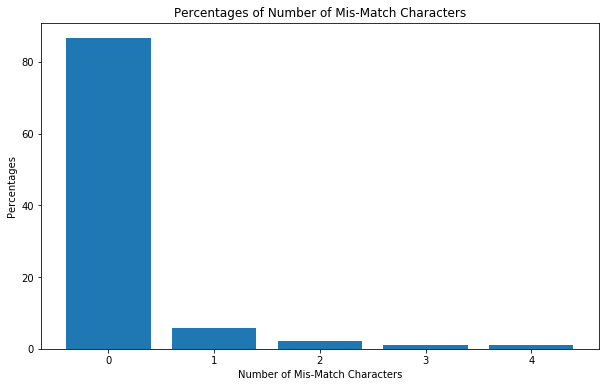

0  Mis-Match Characters Percentage:  86.58  %
1  Mis-Match Characters Percentage:  5.78  %
2  Mis-Match Characters Percentage:  2.15  %
3  Mis-Match Characters Percentage:  1.18  %
4  Mis-Match Characters Percentage:  1.07  %


In [80]:
mis_match_character_analysis_plot(mis_match_cnts_1,12000)

**Synth Text Test Data**

In [84]:
test_img_names=test_data['ImageName'].values
test_labels=test_data['Labels'].values

In [85]:
synth_test_accuracy,synth_test_letter_acc,synth_test_letter_cnt,synth_test_mis_match=test_data_output_Prediction(model,test_img_names,test_labels)

Processed  1000  Images
Processed  2000  Images
Processed  3000  Images
Processed  4000  Images
Processed  5000  Images
Processed  6000  Images
Processed  7000  Images
Processed  8000  Images
Processed  9000  Images
Processed  10000  Images
Processed  11000  Images
Processed  12000  Images
Processed  13000  Images
Processed  14000  Images
Processed  15000  Images
Time Taken for Processing:  0:21:50.478253


In [86]:
print("Model Output Accuracy: ",(synth_test_accuracy/len(test_labels))*100, " %")
print("Model Output Letter Accuracy: ",(synth_test_letter_acc/synth_test_letter_cnt)*100, " %")

Model Output Accuracy:  87.08666666666667  %
Model Output Letter Accuracy:  94.48166697375254  %


In [87]:
model_1_test_mis_match_dict=Counter(synth_test_mis_match)

**Model 1 Test Data Prediction Analysis upto 4 Character Mis-Matches**

In [88]:
mis_match_cnts_2=[]
for i in range(5):
    mis_match_cnts_2.append(model_1_test_mis_match_dict[i])

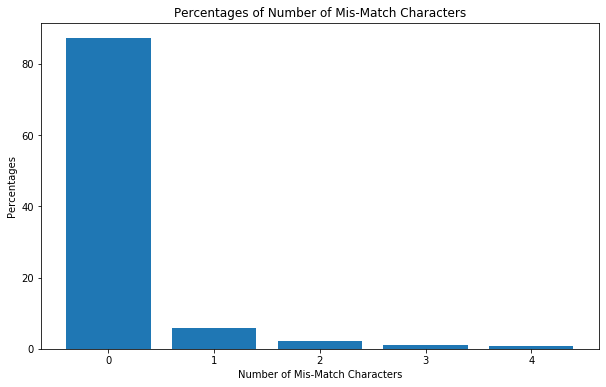

0  Mis-Match Characters Percentage:  87.19  %
1  Mis-Match Characters Percentage:  5.85  %
2  Mis-Match Characters Percentage:  2.1  %
3  Mis-Match Characters Percentage:  1.17  %
4  Mis-Match Characters Percentage:  0.91  %


In [89]:
mis_match_character_analysis_plot(mis_match_cnts_2,15000)

### 13.4. Model 2 Predictions

For Output Prediction, load the model achitecture  defined above for Predict stage which takes in the image as input and outputs a 48x37 matrix as ouput for each input image

In [90]:
model_2=Image_text_recogniser_model_2('predict')

The Best Weights for the Model are stored in BestGRUModelWeights Folder, loading the stored best weights for Model 2 for prediction

In [91]:
model_2.load_weights('Final_GRU_Model_Best_Weights/Best_Img_recog_GRU_RAdam_model_run_weights.h5')

**Synth Text Validation Data Prediction**

In [92]:
val_img_names=val_data['ImageName'].values
val_labels=val_data['Labels'].values

In [93]:
synth_val_accuracy,synth_val_letter_acc,synth_val_letter_cnt,synth_val_mis_match=test_data_output_Prediction(model_2,val_img_names,val_labels)

Processed  1000  Images
Processed  2000  Images
Processed  3000  Images
Processed  4000  Images
Processed  5000  Images
Processed  6000  Images
Processed  7000  Images
Processed  8000  Images
Processed  9000  Images
Processed  10000  Images
Processed  11000  Images
Processed  12000  Images
Time Taken for Processing:  0:14:31.055968


In [94]:
print("Model Output Accuracy: ",(synth_val_accuracy/len(val_labels))*100, " %")
print("Model Output Letter Accuracy: ",(synth_val_letter_acc/synth_val_letter_cnt)*100, " %")

Model Output Accuracy:  81.86666666666666  %
Model Output Letter Accuracy:  92.10611116308563  %


In [95]:
model_2_val_mis_match_dict=Counter(synth_val_mis_match)

**Model 2 Validation Data Prediction Analysis upto 4 Character Mis-Matches**

In [96]:
mis_match_cnts_3=[]
for i in range(5):
    mis_match_cnts_3.append(model_2_val_mis_match_dict[i])

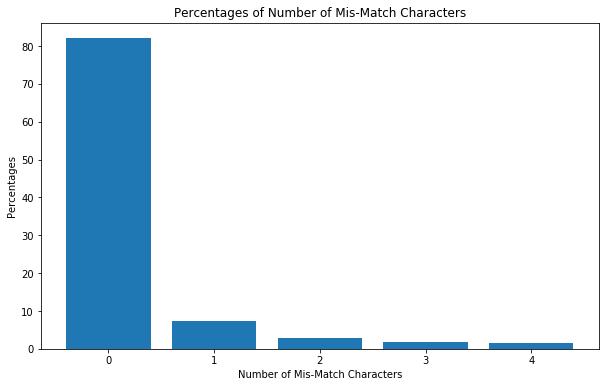

0  Mis-Match Characters Percentage:  82.06  %
1  Mis-Match Characters Percentage:  7.32  %
2  Mis-Match Characters Percentage:  2.88  %
3  Mis-Match Characters Percentage:  1.85  %
4  Mis-Match Characters Percentage:  1.41  %


In [97]:
mis_match_character_analysis_plot(mis_match_cnts_3,12000)

**Synth Text Test Data**

In [98]:
test_img_names=test_data['ImageName'].values
test_labels=test_data['Labels'].values

In [99]:
synth_test_accuracy,synth_test_letter_acc,synth_test_letter_cnt,synth_test_mis_match=test_data_output_Prediction(model_2,test_img_names,test_labels)

Processed  1000  Images
Processed  2000  Images
Processed  3000  Images
Processed  4000  Images
Processed  5000  Images
Processed  6000  Images
Processed  7000  Images
Processed  8000  Images
Processed  9000  Images
Processed  10000  Images
Processed  11000  Images
Processed  12000  Images
Processed  13000  Images
Processed  14000  Images
Processed  15000  Images
Time Taken for Processing:  0:18:08.747058


In [100]:
print("Model Output Accuracy: ",(synth_test_accuracy/len(test_labels))*100, " %")
print("Model Output Letter Accuracy: ",(synth_test_letter_acc/synth_test_letter_cnt)*100, " %")

Model Output Accuracy:  82.43333333333334  %
Model Output Letter Accuracy:  92.63425739922326  %


In [101]:
model_2_test_mis_match_dict=Counter(synth_test_mis_match)

**Model 2 Test Data Prediction Analysis upto 4 Character Mis-Matches**

In [102]:
mis_match_cnts_4=[]
for i in range(5):
    mis_match_cnts_4.append(model_2_test_mis_match_dict[i])

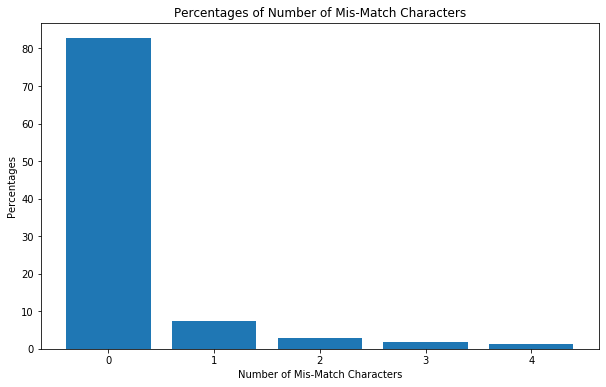

0  Mis-Match Characters Percentage:  82.73  %
1  Mis-Match Characters Percentage:  7.45  %
2  Mis-Match Characters Percentage:  2.82  %
3  Mis-Match Characters Percentage:  1.76  %
4  Mis-Match Characters Percentage:  1.33  %


In [103]:
mis_match_character_analysis_plot(mis_match_cnts_4,15000)

## 14. Results

1. **Model 1:** Model 1 Architecture consists of Convulution Layers, LSTM Units for RNN and uses Adam Optimizer
2. **Model 2:** Model 2 Architecture consists of Convulution Layers, GRU Units for RNN and uses RAdam Optimizer
3. **Val:** Denotes Synth Text Validation Data containing 12000 Images
4. **Test:** Denotes Synth Text Test Data containing 15000 Images
5. **0 MM(%):** Denotes % of points out of total points which have 0 character mis-match between Predicted and Actual Labels
6. **1 MM(%):** Denotes % of points out of total points which have 1 character mis-match between Predicted and Actual Labels

In [104]:
from prettytable import PrettyTable

pt = PrettyTable()

pt.field_names = ["Model", "Data", "Accuracy","Letter Accuracy", "0 MM(%)", "1 MM (%)"]

pt.add_row(["Model 1", "Val", 86.47, 94.01, 86.58, 5.78])

pt.add_row(["Model 1", "Test", 87.98, 94.48, 87.19, 5.85])

pt.add_row(["Model 2", "Val", 81.86, 92.1, 82.06, 7.32])

pt.add_row(["Model 2", "Test", 82.43, 92.63, 82.73, 7.45])

print(pt)

+---------+------+----------+-----------------+---------+----------+
|  Model  | Data | Accuracy | Letter Accuracy | 0 MM(%) | 1 MM (%) |
+---------+------+----------+-----------------+---------+----------+
| Model 1 | Val  |  86.47   |      94.01      |  86.58  |   5.78   |
| Model 1 | Test |  87.98   |      94.48      |  87.19  |   5.85   |
| Model 2 | Val  |  81.86   |       92.1      |  82.06  |   7.32   |
| Model 2 | Test |  82.43   |      92.63      |  82.73  |   7.45   |
+---------+------+----------+-----------------+---------+----------+


## 15. Summary

1. The 2 Image Text Recognition Model Architectures are Trained on 200000 Synth Text Images of Variable length Labels which are different from Validation Data containing 12000 images and Test Data Containing 15000 images.
2. Model 1 Trained on 200000 images from Synth Text Images performs reasonably well on Unseen 15000 Test Images of Variable length labels with an accuracy of ~88% and letter accuracy of ~94%
3. Model 2 also Trained on same 200000 images has an accuracy of ~82% and letter accuracy of ~93% on 15000 Test Images of Variable length labels
4. Both the Models have high percentage (>82%) of 0 mis-match character points between Actual and Predicted Labels 